In [65]:
import os
path_to_folder = "/dlabscratch1/baldwin/pause2/PauseToken/logs/sft/runs/2024-08-29_10-23-33/"
model_path = os.path.join(path_to_folder, "final")
path_to_test_res = "/dlabscratch1/baldwin/pause2/PauseToken/logs/sft/runs/2024-08-29_13-15-50/test_results.json" #os.path.join(path_to_folder, "test_results.json")
path_to_gt = "/dlabscratch1/baldwin/pause2/PauseToken/data/gsm8k_json/gsm8k/train.json"

In [2]:
from src.model.components.control_token_wrappers.pause_wrapper import PauseClassifierWrapper
from transformers import AutoTokenizer
model = PauseClassifierWrapper.from_pretrained(model_path, device_map="cpu")
tokenizer = AutoTokenizer.from_pretrained(model_path)
model.eval()

/home/baldwin/.conda/envs/lm_stable_baselines/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]/home/baldwin/.conda/envs/lm_stable_baselines/lib/python3.11/site-packages/torch/nn/modules/module.py:2068: UserWarning: for model.embed_tokens.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(f'for {key}: copying from a non-meta parameter in the checkpoint to a meta '
/home/baldwin/.conda/envs/lm_stable_baselines/lib/python3.11/site-packages/torch/nn/modules/module.py:2068: UserWarning: for model.layers.0.self_at

PauseClassifierWrapper(
  (language_model): MistralForCausalLM(
    (model): MistralModel(
      (embed_tokens): ExtendedEmbedding(
        (original_embedding): Embedding(32000, 4096)
        (new_embedding): Embedding(1, 4096)
      )
      (layers): ModuleList(
        (0-31): 32 x MistralDecoderLayer(
          (self_attn): MistralSdpaAttention(
            (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
            (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
            (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
            (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
            (rotary_emb): MistralRotaryEmbedding()
          )
          (mlp): MistralMLP(
            (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
            (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
            (down_proj): Linear(in_features=14336, out_features=4096, bias=False)


In [3]:
pause_embedding = model.language_model.get_input_embeddings().new_embedding.weight

lm_embeddings = model.language_model.get_input_embeddings().original_embedding.weight

In [4]:
import torch

#compute the cosine similarity between the pause embeddings and the original embeddings
cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)
similarity = cos(pause_embedding, lm_embeddings)
#compute the l2 norm of the difference between the pause embeddings and the original embeddings
l2 = torch.nn.PairwiseDistance(p=2)
l2_norm = l2(pause_embedding, lm_embeddings)

similarity.shape, l2_norm.shape

(torch.Size([32000]), torch.Size([32000]))

In [29]:
k = 10
#find indices of the top 10 most similar embeddings
top_k_cos = torch.argsort(similarity, descending=True)[:k]
top_k_l2 = torch.argsort(l2_norm, descending=False)[:k]
top_k_cos_least = torch.argsort(similarity, descending=False)[:k]
top_k_l2_least = torch.argsort(l2_norm, descending=True)[:k]
from prettytable import PrettyTable

t_cos = PrettyTable(["rank", "token_id", "token", "cosine similarity"])

for i, idx in enumerate(top_k_cos):
    t_cos.add_row([i+1, idx.item(), repr(tokenizer.convert_ids_to_tokens(idx.item())), round(similarity[idx].item(),5)])

t_l2 = PrettyTable(["rank", "token_id", "token", "l2 norm"])
for i, idx in enumerate(top_k_l2):
    t_l2.add_row([i+1, idx.item(), repr(tokenizer.convert_ids_to_tokens(idx.item())), round(l2_norm[idx].item(),5)])
    
t_cos_least = PrettyTable(["rank", "token_id", "token", "cosine similarity"])

for i, idx in enumerate(top_k_cos_least):
    t_cos_least.add_row([i+1, idx.item(), repr(tokenizer.convert_ids_to_tokens(idx.item())), round(similarity[idx].item(),5)])
    
t_l2_least = PrettyTable(["rank", "token_id", "token", "l2 norm"])
for i, idx in enumerate(top_k_l2_least):
    t_l2_least.add_row([i+1, idx.item(), repr(tokenizer.convert_ids_to_tokens(idx.item())), round(l2_norm[idx].item(),5)])

In [30]:
print("Top 10 most similar embeddings by cosine similarity")
print(t_cos)

Top 10 most similar embeddings by cosine similarity
+------+----------+----------+-------------------+
| rank | token_id |  token   | cosine similarity |
+------+----------+----------+-------------------+
|  1   |  31759   | '\ufeff' |       0.072       |
|  2   |   387    |   '▁-'   |      0.07159      |
|  3   |  31261   | '\uf0d8' |      0.07004      |
|  4   |   583    |   '▁_'   |      0.06886      |
|  5   |  28705   |   '▁'    |      0.06869      |
|  6   |  30638   |  '\x0b'  |      0.06862      |
|  7   |   1040   |   '▁—'   |      0.06463      |
|  8   |  13958   |   '^^'   |      0.06438      |
|  9   |    13    | '<0x0A>' |      0.06348      |
|  10  |  24075   |  'odot'  |      0.06279      |
+------+----------+----------+-------------------+


In [31]:
print("Top 10 most similar embeddings by l2 norm")
print(str(t_l2))

Top 10 most similar embeddings by l2 norm
+------+----------+---------+---------+
| rank | token_id |  token  | l2 norm |
+------+----------+---------+---------+
|  1   |  30638   |  '\x0b' | 0.21605 |
|  2   |   7608   | '▁*/\r' | 0.21611 |
|  3   |  20692   | '▁},\r' | 0.21612 |
|  4   |  14756   | '/**\r' | 0.21613 |
|  5   |  10278   |  "',\r" | 0.21615 |
|  6   |   9823   |  '*/\r' | 0.21619 |
|  7   |  18759   |  "';\r" | 0.21621 |
|  8   |  31236   |  '\x1d' | 0.21621 |
|  9   |  26407   |  '};\r' | 0.21622 |
|  10  |  11880   |  '";\r' | 0.21626 |
+------+----------+---------+---------+


In [32]:
print("Top 10 least similar embeddings by cosine similarity")
print(t_cos_least)

Top 10 least similar embeddings by cosine similarity
+------+----------+-------------+-------------------+
| rank | token_id |    token    | cosine similarity |
+------+----------+-------------+-------------------+
|  1   |  22639   | '▁clearing' |      -0.06196     |
|  2   |  26663   |    'Bay'    |      -0.06178     |
|  3   |  23702   |   '▁Pool'   |      -0.06039     |
|  4   |  17827   |  '▁belongs' |      -0.05926     |
|  5   |   9009   |  '▁monitor' |      -0.05742     |
|  6   |  14734   |    'uego'   |      -0.0574      |
|  7   |   6833   |  '▁bright'  |      -0.05739     |
|  8   |   4909   |   'Entry'   |      -0.05628     |
|  9   |   5124   |    '}$.'    |      -0.05618     |
|  10  |   7980   |   '▁worry'  |      -0.05594     |
+------+----------+-------------+-------------------+


In [33]:
print("Top 10 least similar embeddings by l2 norm")
print(str(t_l2_least))

Top 10 least similar embeddings by l2 norm
+------+----------+-------------+---------+
| rank | token_id |    token    | l2 norm |
+------+----------+-------------+---------+
|  1   |   1566   |     'ww'    | 0.33305 |
|  2   |  12645   |  '▁släktet' | 0.31698 |
|  3   |  29985   |     '😭'    | 0.31568 |
|  4   |  31491   |     '￼'     | 0.31564 |
|  5   |  30464   |     '😊'    | 0.31379 |
|  6   |  29196   |     '😂'    | 0.31212 |
|  7   |  13129   |  '▁listade' | 0.31173 |
|  8   |  18522   | '▁forehead' | 0.31007 |
|  9   |  30379   |     '😅'    | 0.30909 |
|  10  |  30111   |     '很'    | 0.30886 |
+------+----------+-------------+---------+


In [66]:
import json

with open(path_to_test_res, "r") as f:
    test_res = json.load(f)
with open(path_to_gt, "r") as f:
    gt = json.load(f)

In [67]:
import numpy as np
accuracy = np.mean(list(map(lambda x: x["test/accuracy"], test_res)))
accuracy

0.4404852160727824

In [68]:
test_res[0].keys()

dict_keys(['generated_text', 'tokenized_text', 'input', 'predicted_output', 'ground_truth', 'test/accuracy'])

In [69]:
for res in test_res:
    n_pauses = res["generated_text"].count("<|pause|>")
    res["n_pauses"] = n_pauses

In [70]:
#make a plot of number of pauses vs accuracy
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

df = pd.DataFrame(test_res)
df_acc = df.groupby("n_pauses")["test/accuracy"].mean().reset_index()
df_size = df.groupby("n_pauses").size().reset_index().rename(columns={0: "size"})
#merge the two dataframes
merged_df = pd.merge(df_acc, df_size, on="n_pauses")
display(merged_df)


,n_pauses,test/accuracy,size
0,0,0.532864,426
1,1,0.475309,162
2,2,0.466667,105
3,3,0.500000,68
4,4,0.500000,46
...,...,...,...
128,222,0.000000,1
129,241,0.000000,1
130,282,0.000000,1
131,350,1.000000,1


In [71]:
merged_df["size"]/merged_df["size"].sum()

0      0.322972
1      0.122820
2      0.079606
3      0.051554
4      0.034875
         ...   
128    0.000758
129    0.000758
130    0.000758
131    0.000758
132    0.000758
Name: size, Length: 133, dtype: float64

/tmp/ipykernel_755227/2431929903.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned_df = merged_df.groupby('n_pauses_binned').agg({


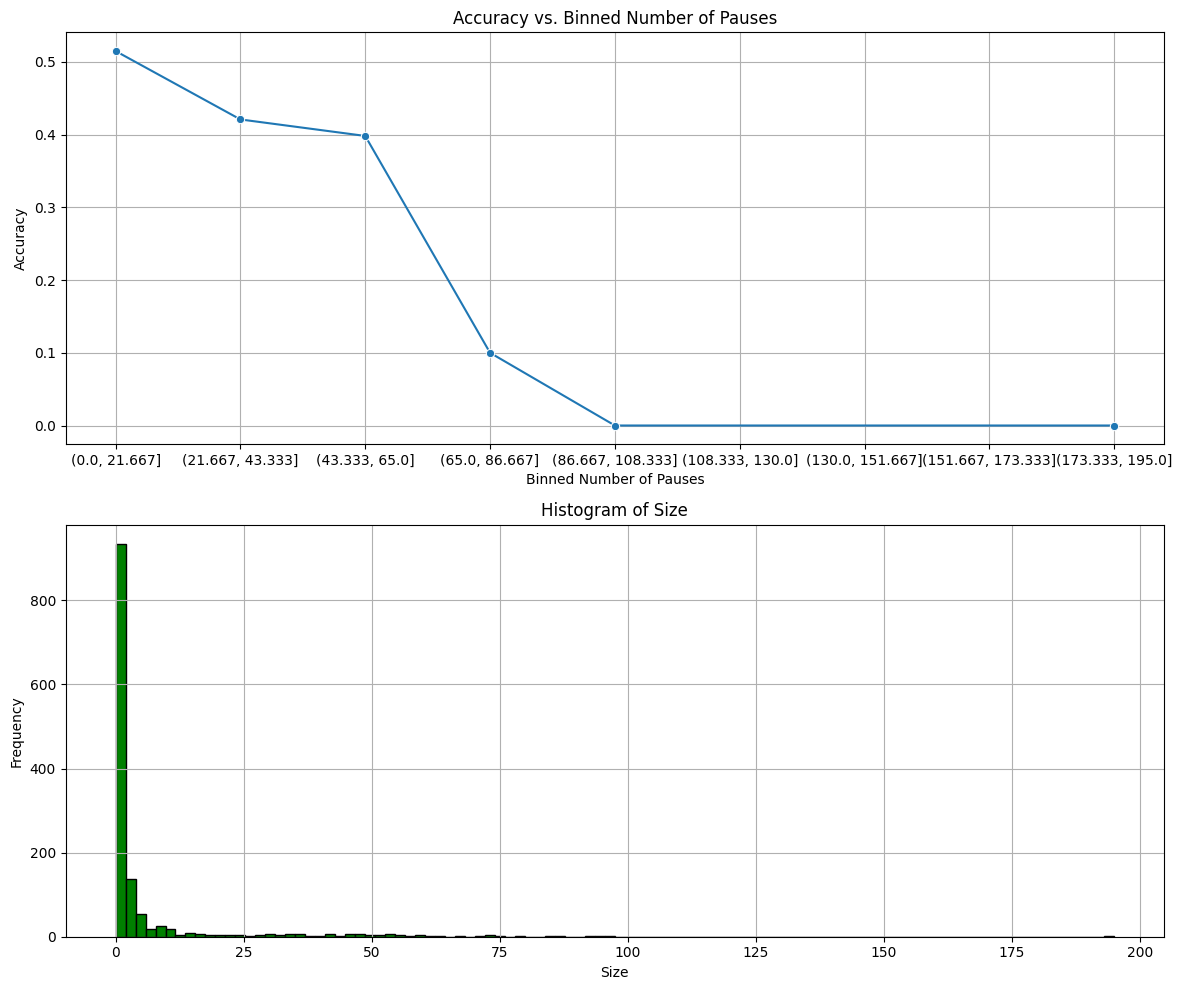

In [55]:
# Define bins for n_pauses
bins = np.linspace(merged_df['n_pauses'].min(), merged_df['n_pauses'].max(), num=10)
merged_df['n_pauses_binned'] = pd.cut(merged_df['n_pauses'], bins=bins)

# Group by the binned n_pauses and calculate the mean accuracy
binned_df = merged_df.groupby('n_pauses_binned').agg({
    'test/accuracy': 'mean',
    'size': 'sum'
}).reset_index()

# Create a figure with two subplots
fig, ax1 = plt.subplots(2, 1, figsize=(12, 10))

# Plot 1: Accuracy vs Binned Number of Pauses
sns.lineplot(ax=ax1[0], x=binned_df['n_pauses_binned'].astype(str), y='test/accuracy', data=binned_df, marker='o')
ax1[0].set_title('Accuracy vs. Binned Number of Pauses')
ax1[0].set_xlabel('Binned Number of Pauses')
ax1[0].set_ylabel('Accuracy')
ax1[0].grid(True)

# Plot 2: Histogram of Size
ax1[1].hist(df['n_pauses'], bins=100, color='green', edgecolor='black')
ax1[1].set_title('Histogram of Size')
ax1[1].set_xlabel('Size')
ax1[1].set_ylabel('Frequency')
ax1[1].grid(True)

# Adjust the layout to prevent overlap
plt.tight_layout()

# Show the combined plot
plt.show()

In [60]:
merged_df.head(20)

,n_pauses,test/accuracy,size,n_pauses_binned
0,0,0.491059,727,NaN
1,1,0.470874,206,"(0.0, 21.667]"
2,2,0.484211,95,"(0.0, 21.667]"
3,3,0.395349,43,"(0.0, 21.667]"
4,4,0.633333,30,"(0.0, 21.667]"
5,5,0.347826,23,"(0.0, 21.667]"
6,6,0.461538,13,"(0.0, 21.667]"
7,7,0.000000,6,"(0.0, 21.667]"
8,8,0.533333,15,"(0.0, 21.667]"
9,9,0.363636,11,"(0.0, 21.667]"


In [72]:
merged_df["size"]/merged_df["size"].sum()

0      0.322972
1      0.122820
2      0.079606
3      0.051554
4      0.034875
         ...   
128    0.000758
129    0.000758
130    0.000758
131    0.000758
132    0.000758
Name: size, Length: 133, dtype: float64